In [32]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.time import Time
import textwrap

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Define Functions

In [2]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motors = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields=['torque0', 'torque1', 'raw0', 'raw1', 'calibrated0', 'calibrated1'], 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motors, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

# Get sal object Script messages from each test

In [3]:
# I would like to skip this. Learn to do a better EFD query and just juse the ScriptID

t_start = Time('2022-03-01T15:40:22.143140', scale='utc', format='isot') 
t_end = Time('2022-03-01T18:52:17.886160', scale='utc', format='isot')

In [4]:
summit = 1 #use this for summit testing
efd_client = retrieve_efd_client(summit)

In [5]:
# Get the script messages

messages = await efd_client.select_time_series(
        "lsst.sal.Script.logevent_logMessage", 
        fields=['ScriptID','message'], 
        start=t_start, 
        end=t_end)
messages.reset_index(inplace=True)

In [6]:
messages

,index,ScriptID,message
0,2022-03-01 15:40:22.143000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
1,2022-03-01 15:40:31.330000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
2,2022-03-01 16:16:43.756000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
3,2022-03-01 16:26:45.725000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder L...
4,2022-03-01 16:34:00.933000+00:00,42658886,END -- LVV-2261: Hexapod at 0 - Pathfinder Lin...
5,2022-03-01 16:46:05.840000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg - Pathfi...
6,2022-03-01 17:11:13.165000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg - Pathfi...
7,2022-03-01 17:26:29.561000+00:00,42658886,END -- LVV-2261: Hexapod u=-0.36deg - Pathfind...
8,2022-03-01 17:28:43.191000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.36deg v=-0.36d...
9,2022-03-01 17:31:42.666000+00:00,42658886,START -- LVV-2261: Hexapod u=-0.18deg v=-0.18d...


# Make a dataframe for the rotator data for each test.

In [7]:
# Examine the good tests by hand. Find the START/END pairs with no errors in between them.
# Make a dataframe for each.

runs = [3, 6, 10, 16, 22, 26]
dfs = []

for i in runs:
    
    #print(f'Test #{i} - {messages.message[i]}')
    start_time = Time(messages['index'][i])
    stop_time = Time(messages['index'][i+1])

    df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, start_time, stop_time)
    new = df.assign(test = i) \
            .assign(net_torque = lambda x: 1.0e6*(x.torque0 + x.torque1))
       
    new = new.resample('S').mean() # Resample in 1 second intervals
    
    #new.reset_index(inplace=True)  
    dfs.append(new)

# Reset all the times to start at the first test
display(dfs[0])
zero_time = dfs[0].index[0]
      
for i, run in enumerate(runs):
   dfs[i].index = dfs[i].index - to_offset(dfs[i].index[0] - zero_time)

,actualPosition,torque0,torque1,raw0,raw1,calibrated0,calibrated1,test,net_torque
2022-03-01 16:26:45+00:00,0.000018,-0.000118,0.000216,121960.000000,381456.000000,-0.168830,0.170848,3.0,97.833333
2022-03-01 16:26:46+00:00,0.000081,-0.000168,0.000166,117575.529412,375547.294118,-0.168716,0.171003,3.0,-2.000000
2022-03-01 16:26:47+00:00,-0.000221,-0.000133,0.000201,132283.200000,390588.800000,-0.169109,0.170601,3.0,68.000000
2022-03-01 16:26:48+00:00,-0.000113,-0.000162,0.000172,126507.428571,384158.857143,-0.168955,0.170772,3.0,9.785714
2022-03-01 16:26:49+00:00,-0.000045,-0.000148,0.000186,123704.800000,382060.000000,-0.168879,0.170829,3.0,37.950000
...,...,...,...,...,...,...,...,...,...
2022-03-01 16:33:56+00:00,-0.000027,-0.000221,0.000112,217858.285714,473738.285714,-0.171399,0.168375,3.0,-108.642857
2022-03-01 16:33:57+00:00,-0.000070,-0.000188,0.000145,220500.800000,479118.400000,-0.171469,0.168232,3.0,-42.550000
2022-03-01 16:33:58+00:00,0.000003,-0.000189,0.000145,217435.200000,475631.200000,-0.171386,0.168326,3.0,-44.400000
2022-03-01 16:33:59+00:00,0.000047,-0.000205,0.000128,215048.000000,471772.444444,-0.171323,0.168429,3.0,-77.666667


In [8]:
#print(f'Test #{runs[0]} - {messages.message[runs[0]]}')
#display(dfs[0])

# Make Plots

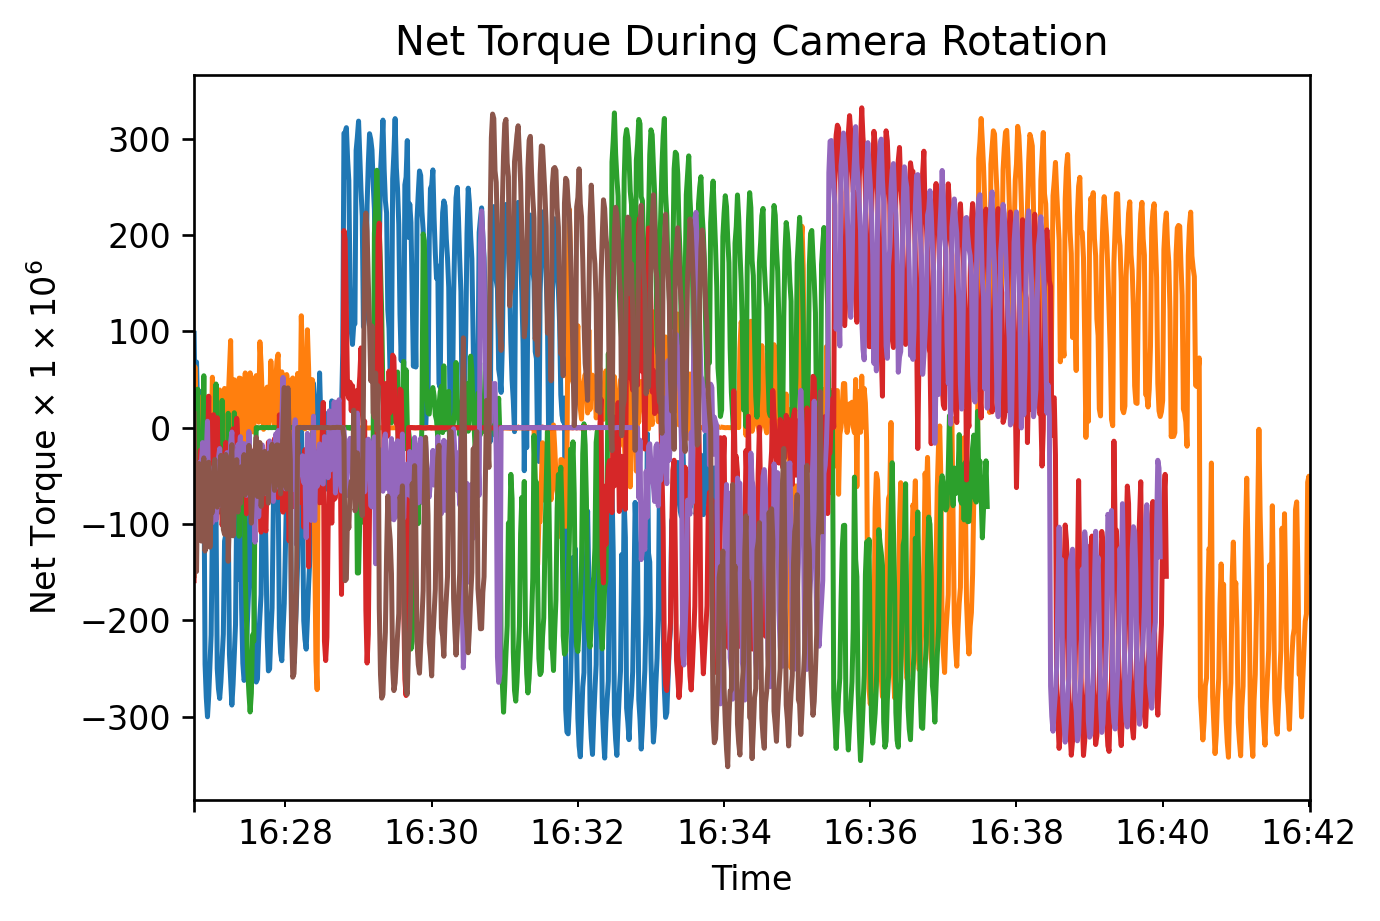

In [9]:
dfs[0].net_torque.plot(label=f'{runs[0]}')
dfs[1].net_torque.plot(label=f'{runs[1]}')
dfs[2].net_torque.plot(label=f'{runs[2]}')
dfs[3].net_torque.plot(label=f'{runs[3]}')
dfs[4].net_torque.plot(label=f'{runs[4]}')
dfs[5].net_torque.plot(label=f'{runs[5]}')

plt.title(r'Net Torque During Camera Rotation')
plt.xlabel(r'Time')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');
#plt.legend(ncol=2, loc='lower left', fontsize=8)


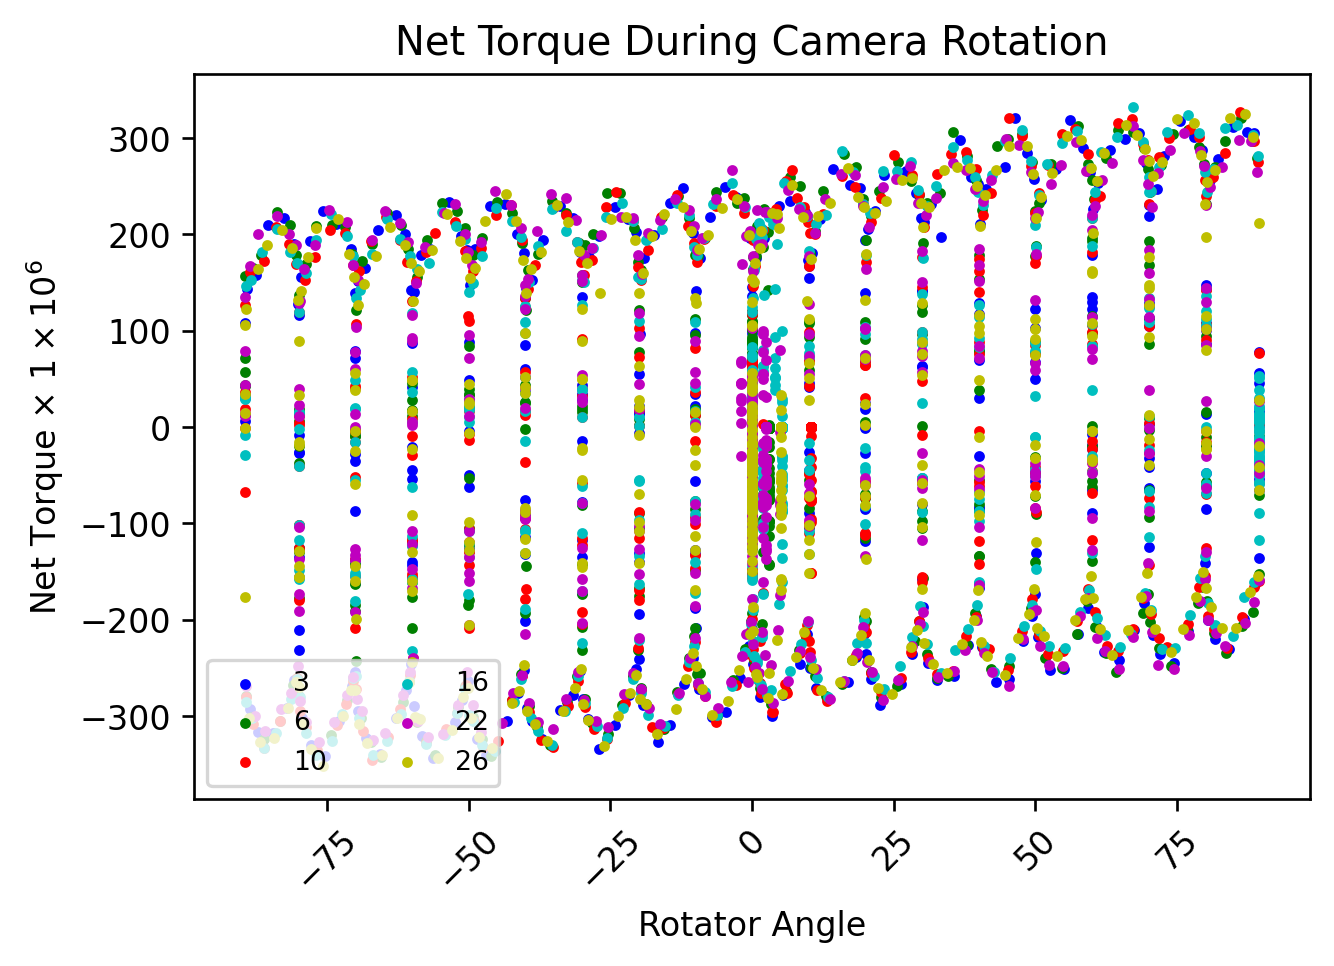

In [10]:
#dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", s=.1)

ax1 = dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", color='b', s=20.0, label=f'{runs[0]}')
ax2 = dfs[1].plot.scatter('actualPosition', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{runs[1]}')
ax3 = dfs[2].plot.scatter('actualPosition', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{runs[2]}')
ax4 = dfs[3].plot.scatter('actualPosition', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{runs[3]}')
ax5 = dfs[4].plot.scatter('actualPosition', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{runs[4]}')
ax6 = dfs[5].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{runs[5]}')


plt.title(r'Net Torque During Camera Rotation')
#plt.ylim(-.001, .001)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

plt.legend(ncol=2, loc='lower left', fontsize=8)

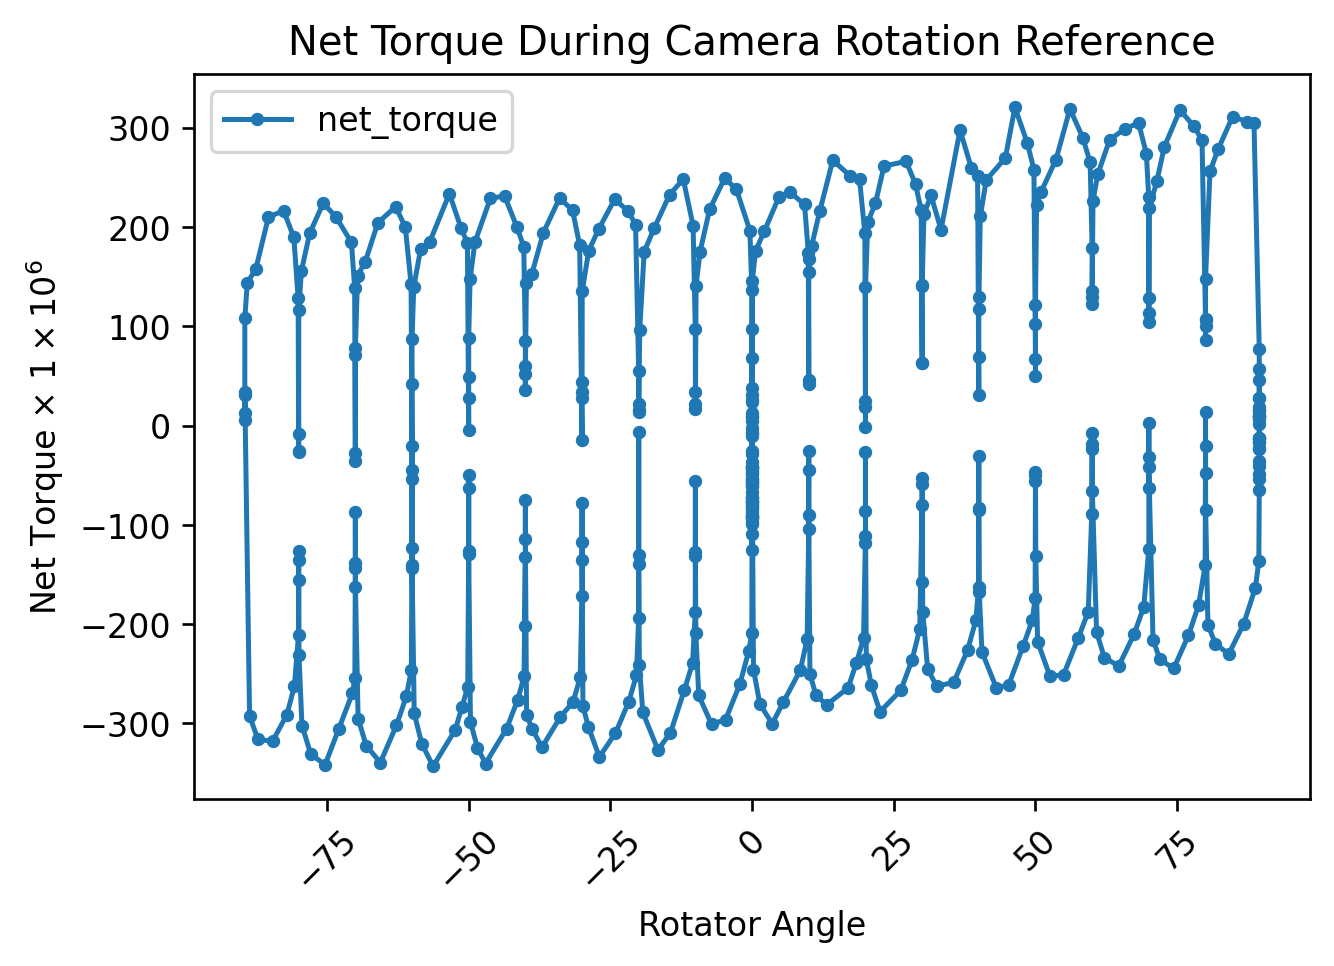

In [11]:
dfs[0].plot('actualPosition', 'net_torque', marker='.')

plt.title(r'Net Torque During Camera Rotation Reference')
#plt.xlim(-90, 0)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

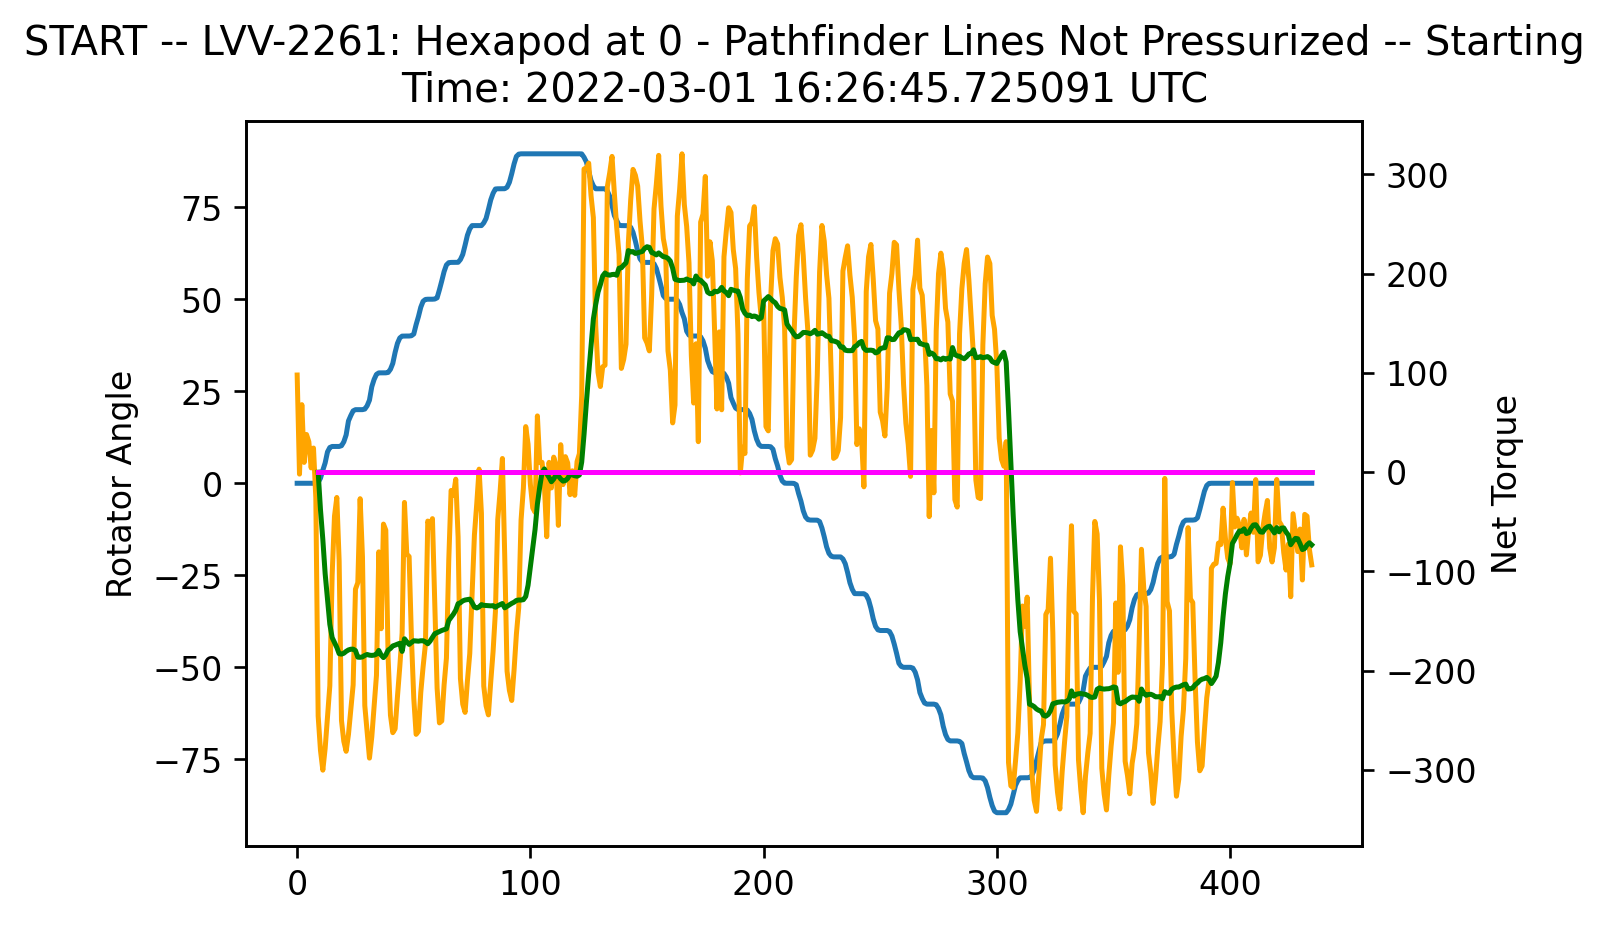

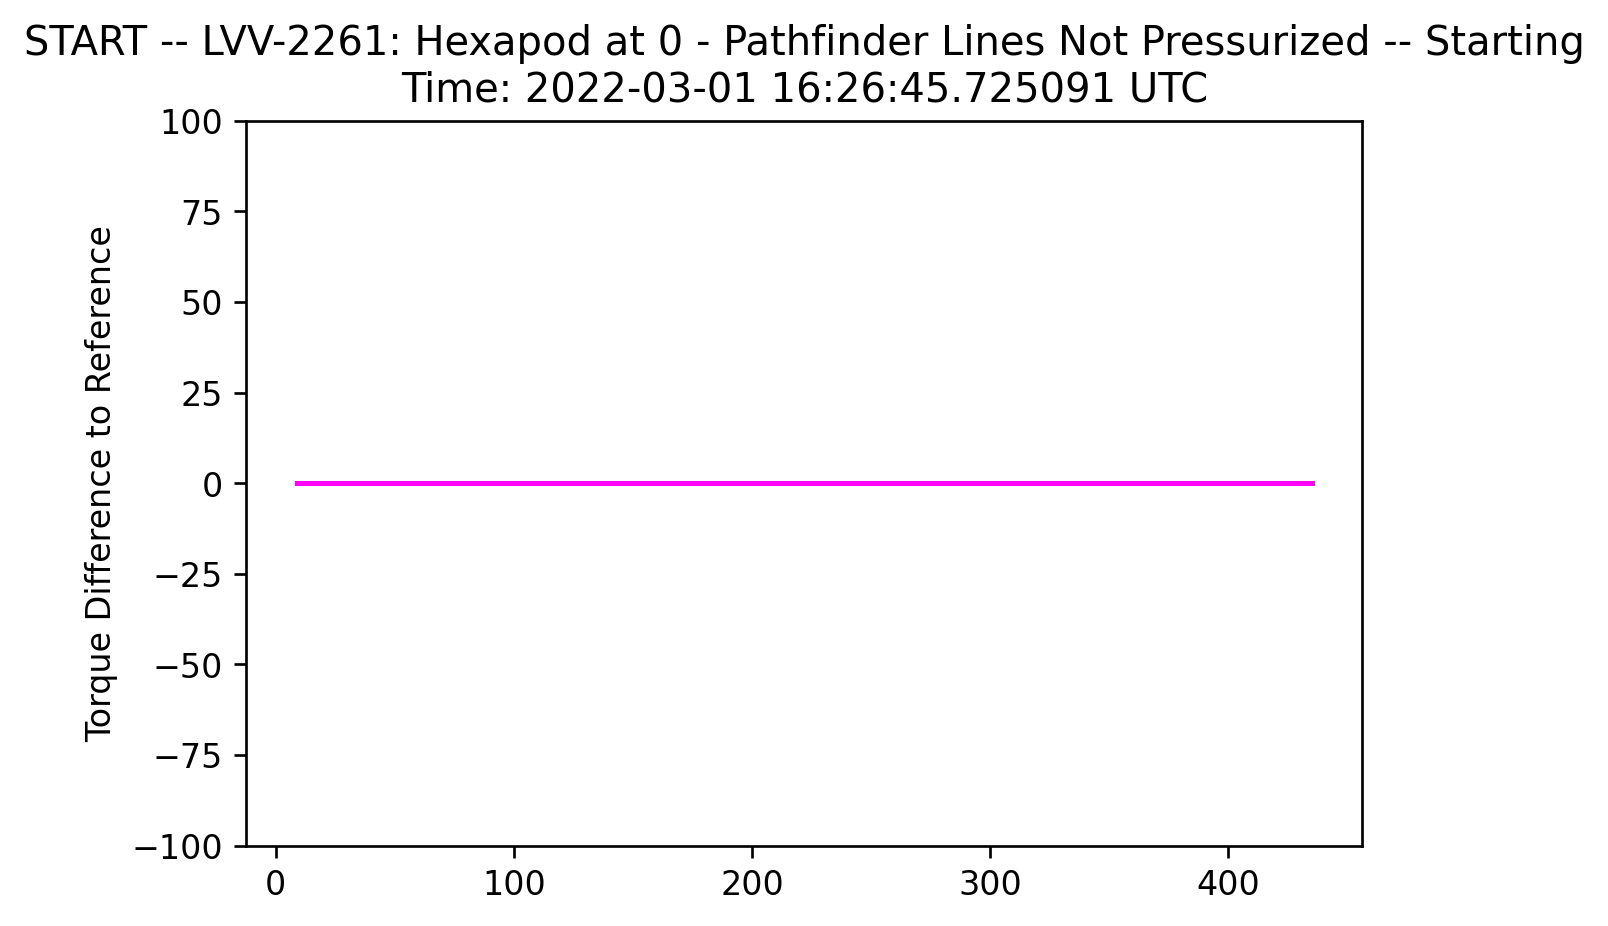

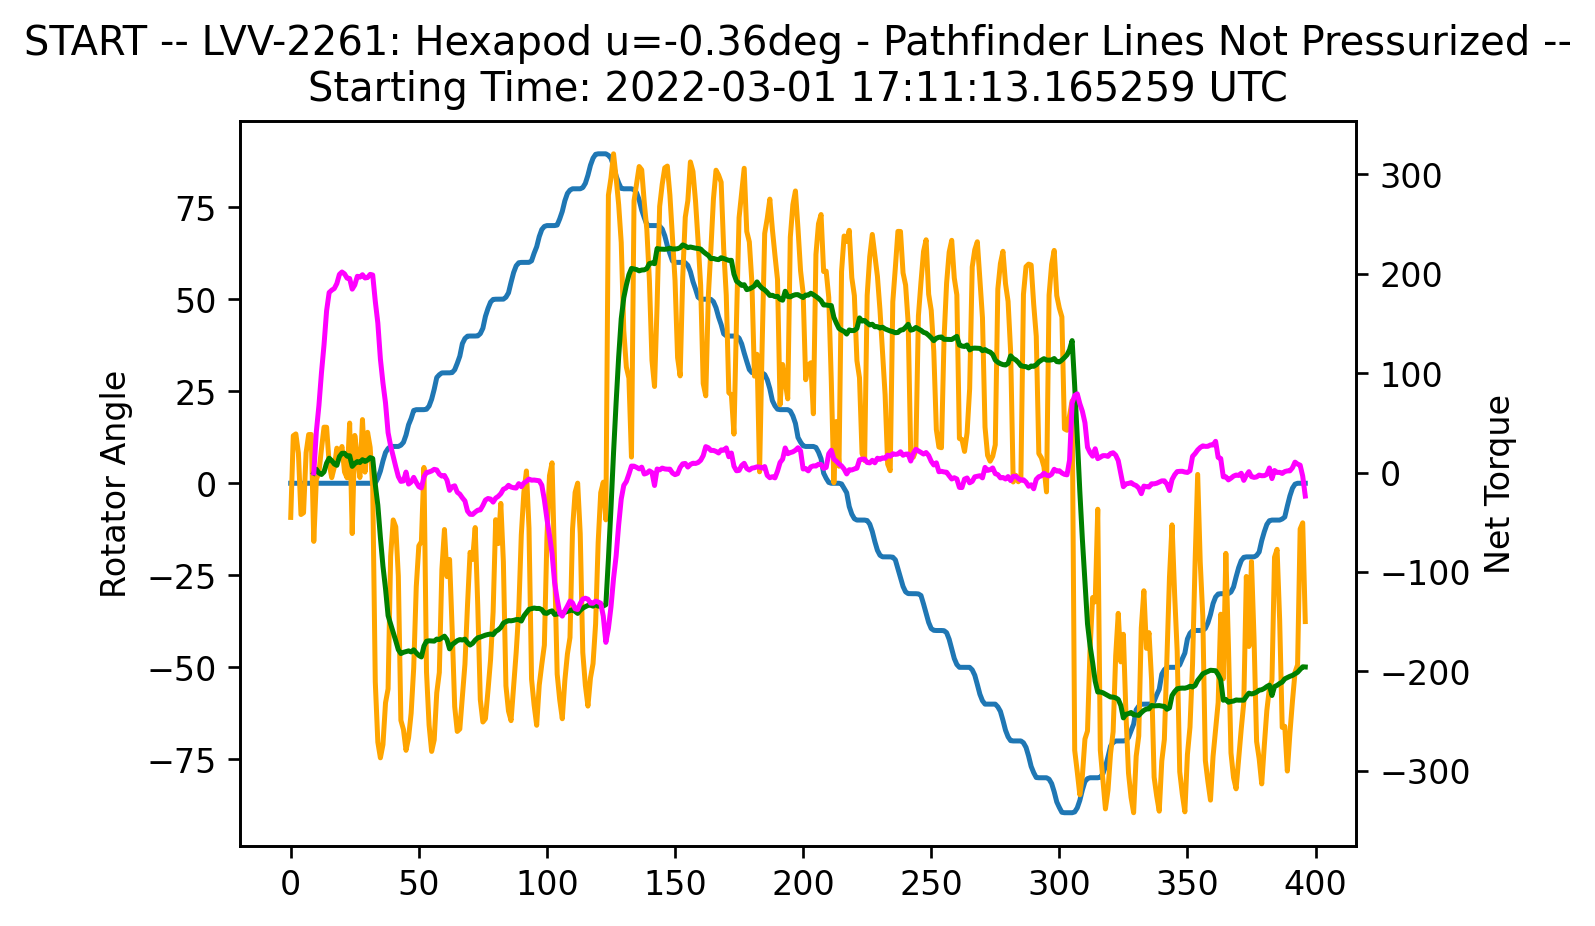

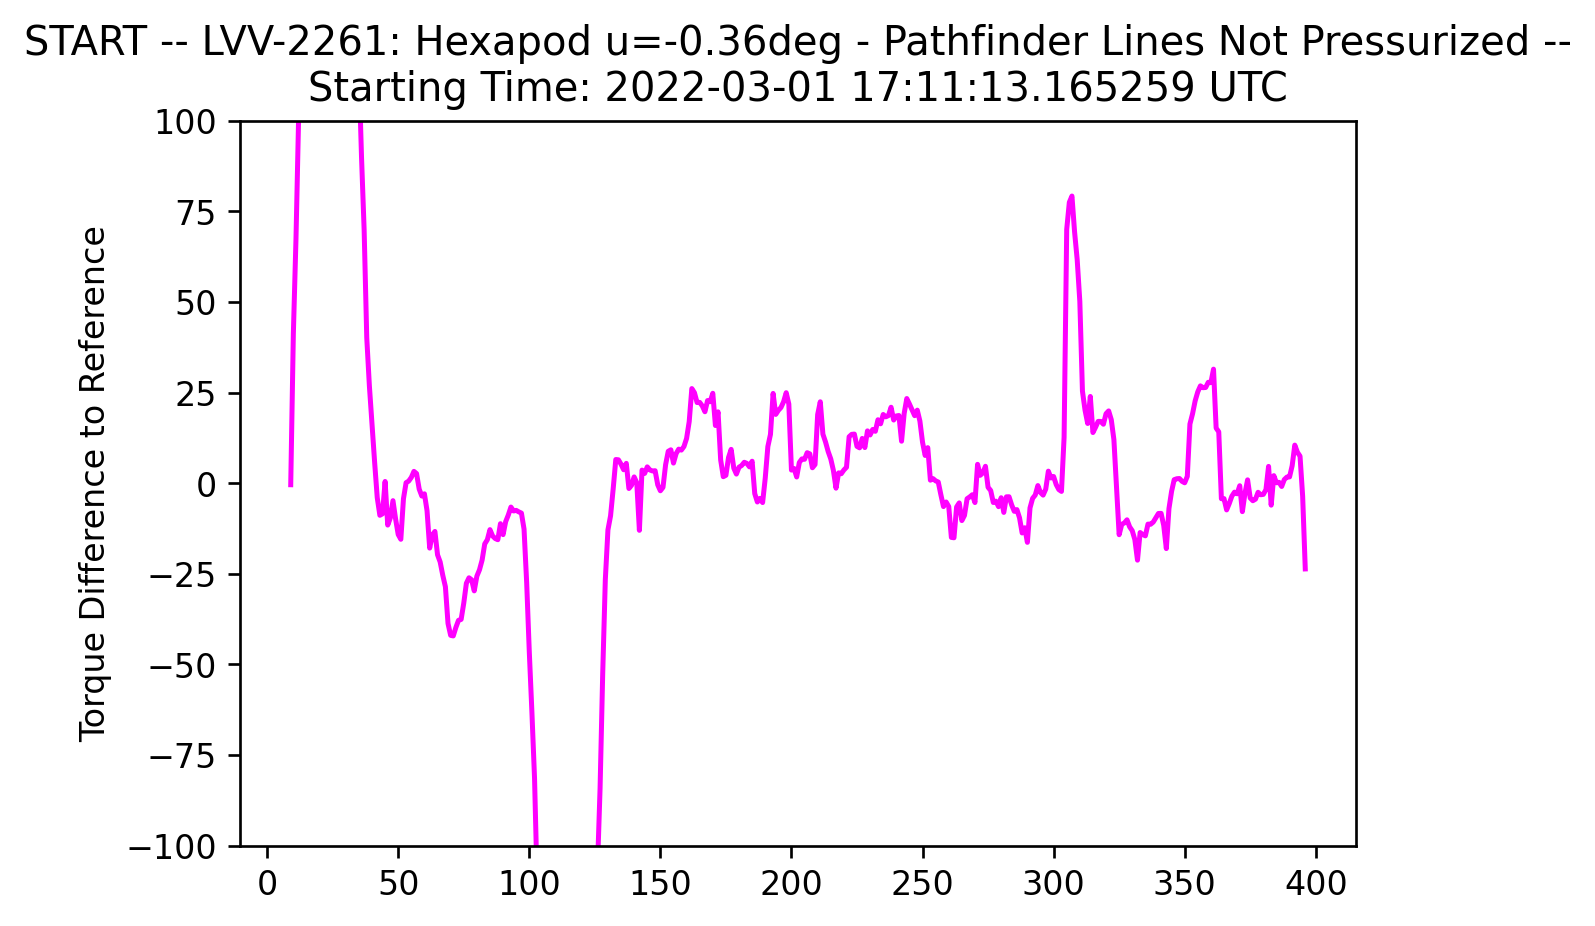

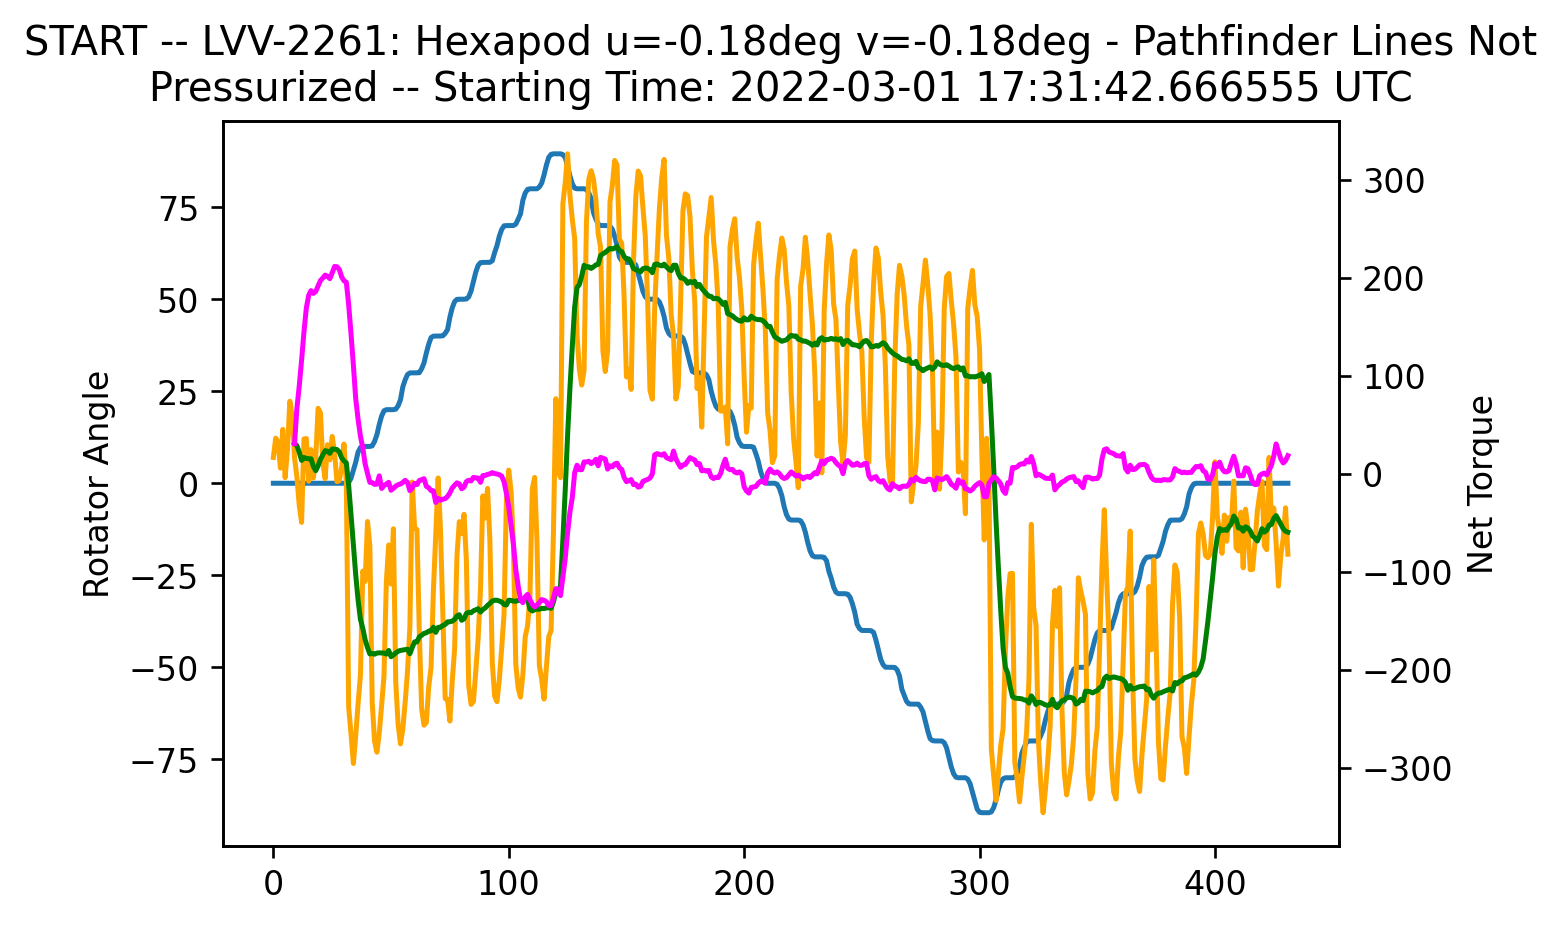

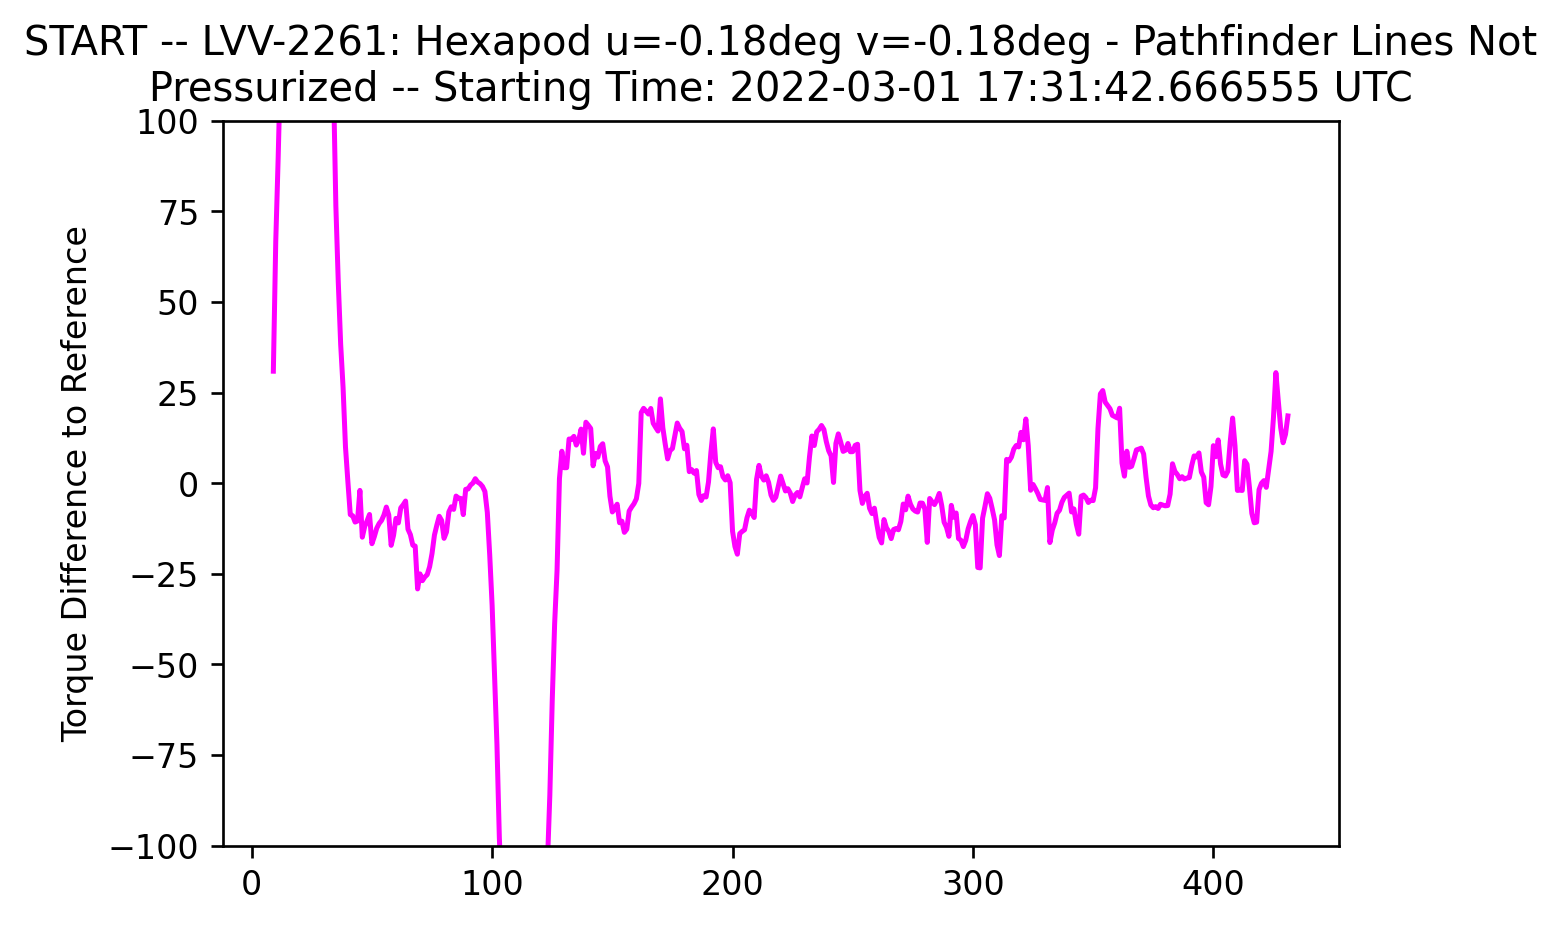

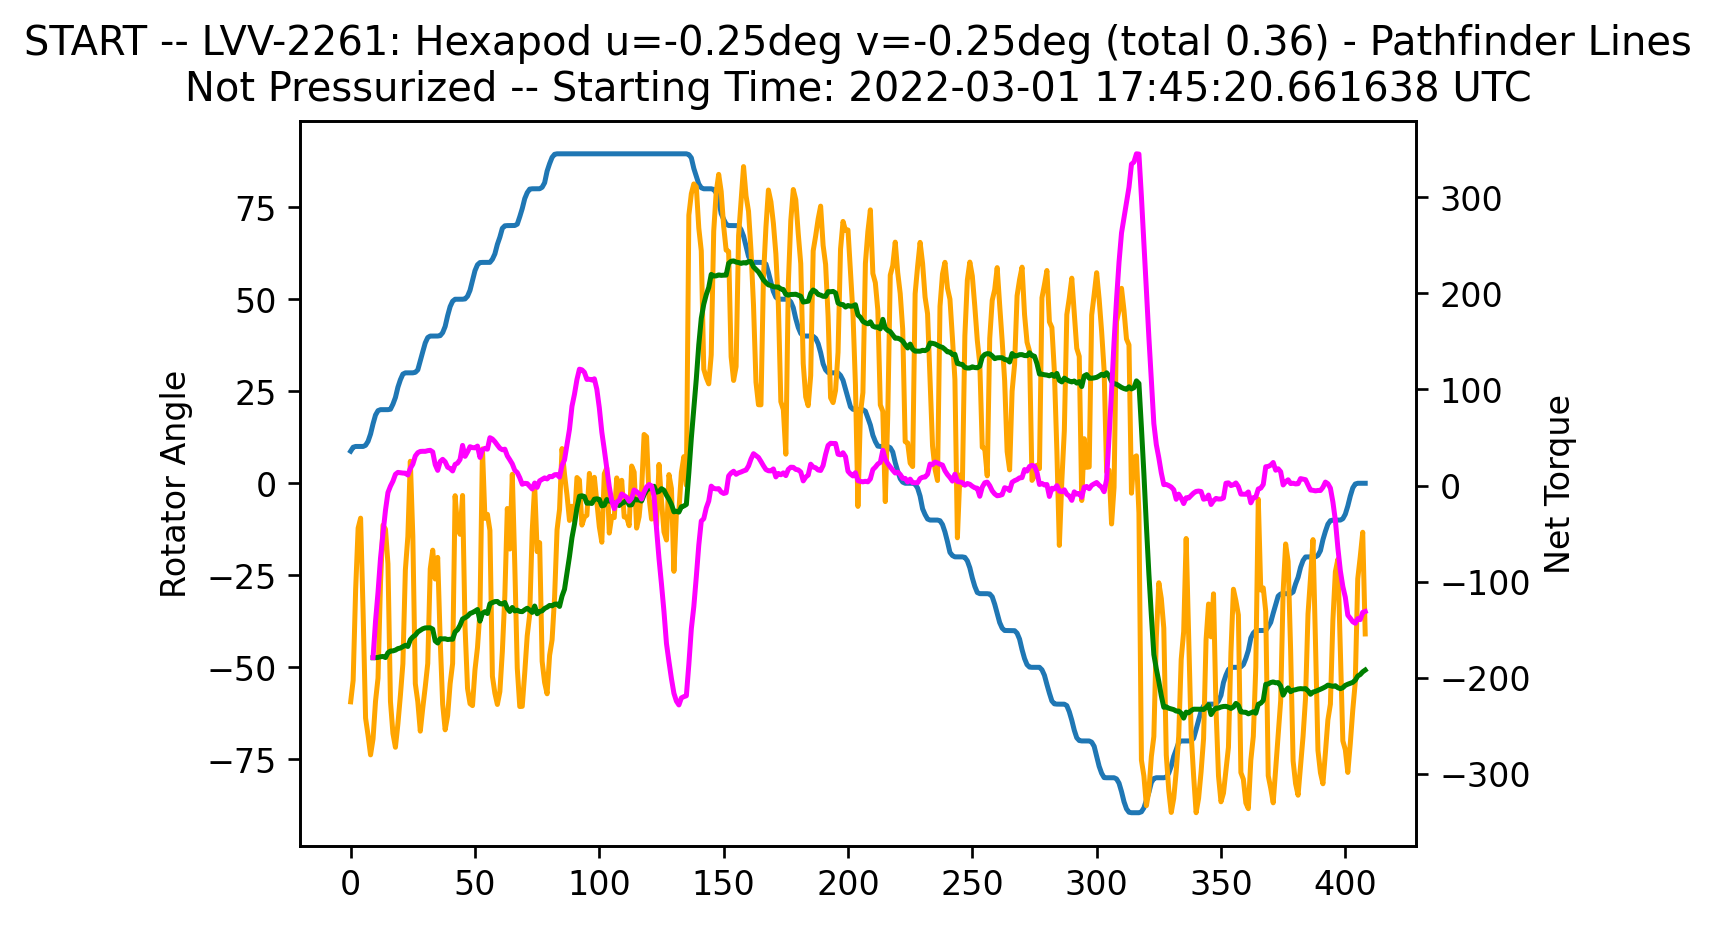

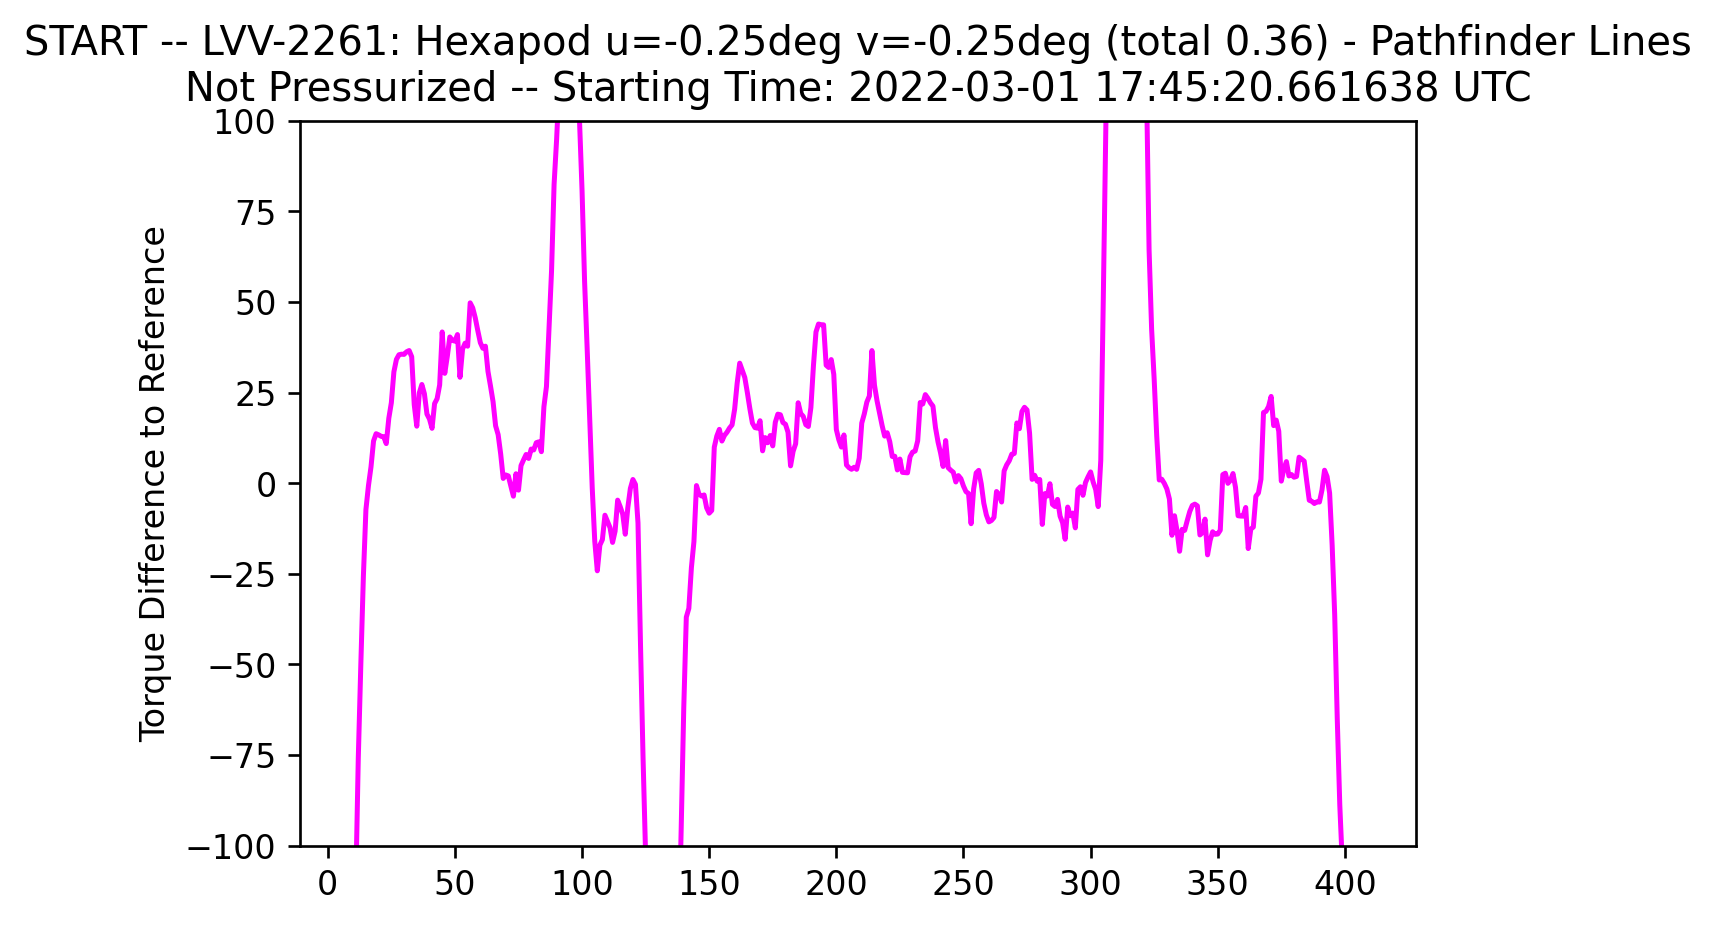

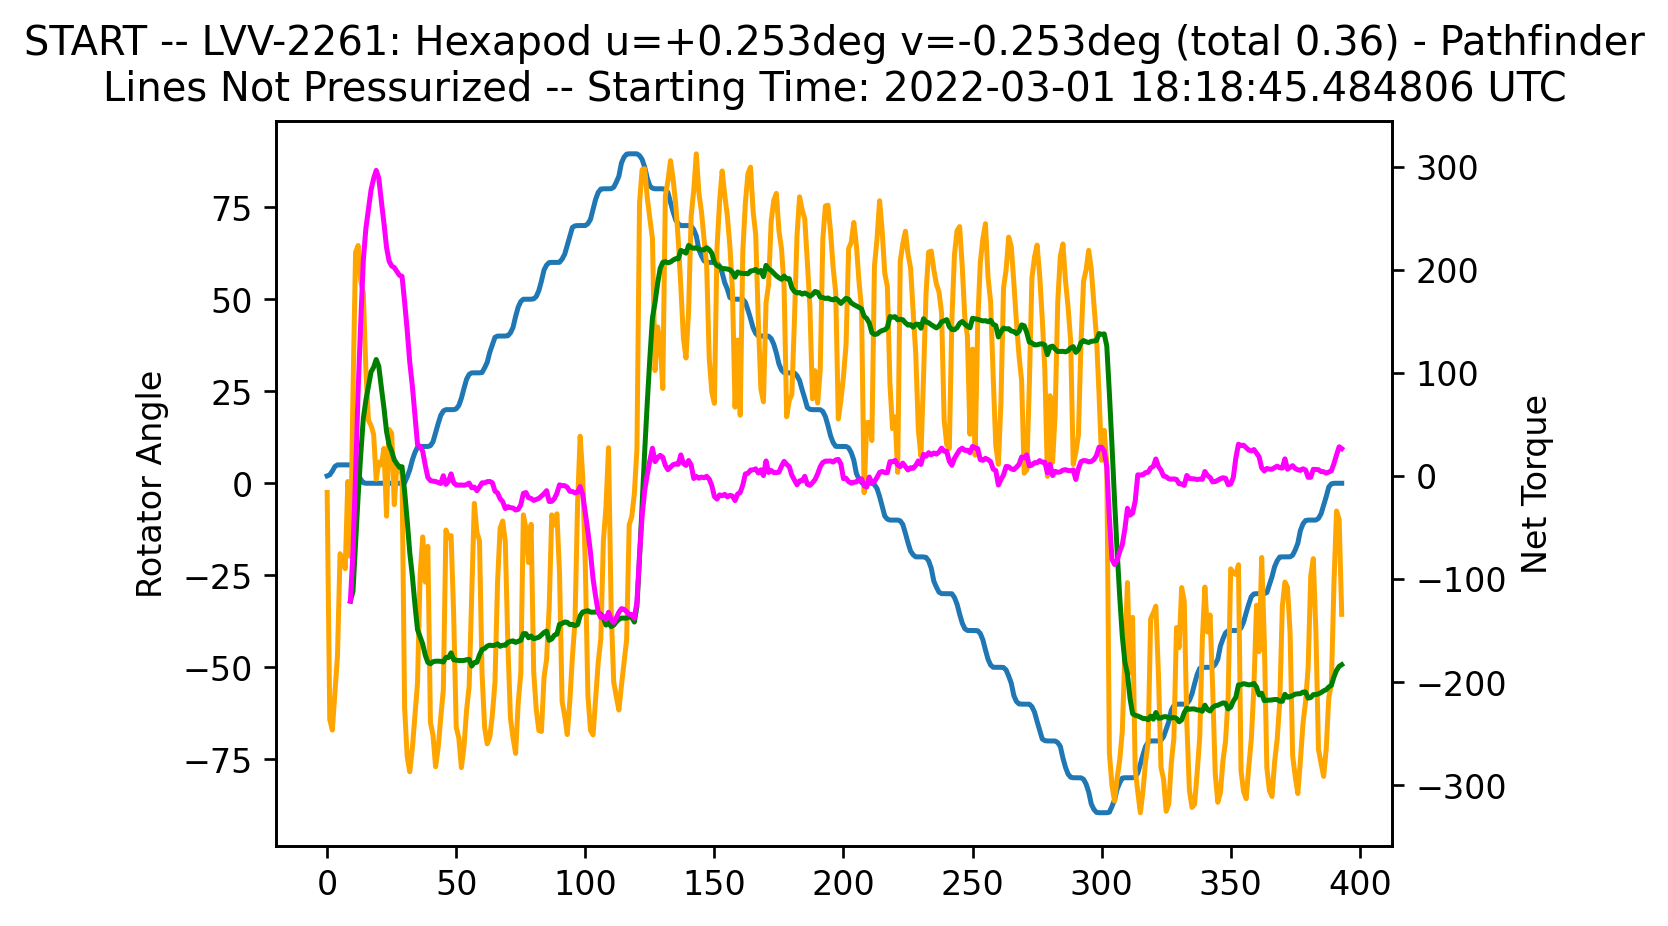

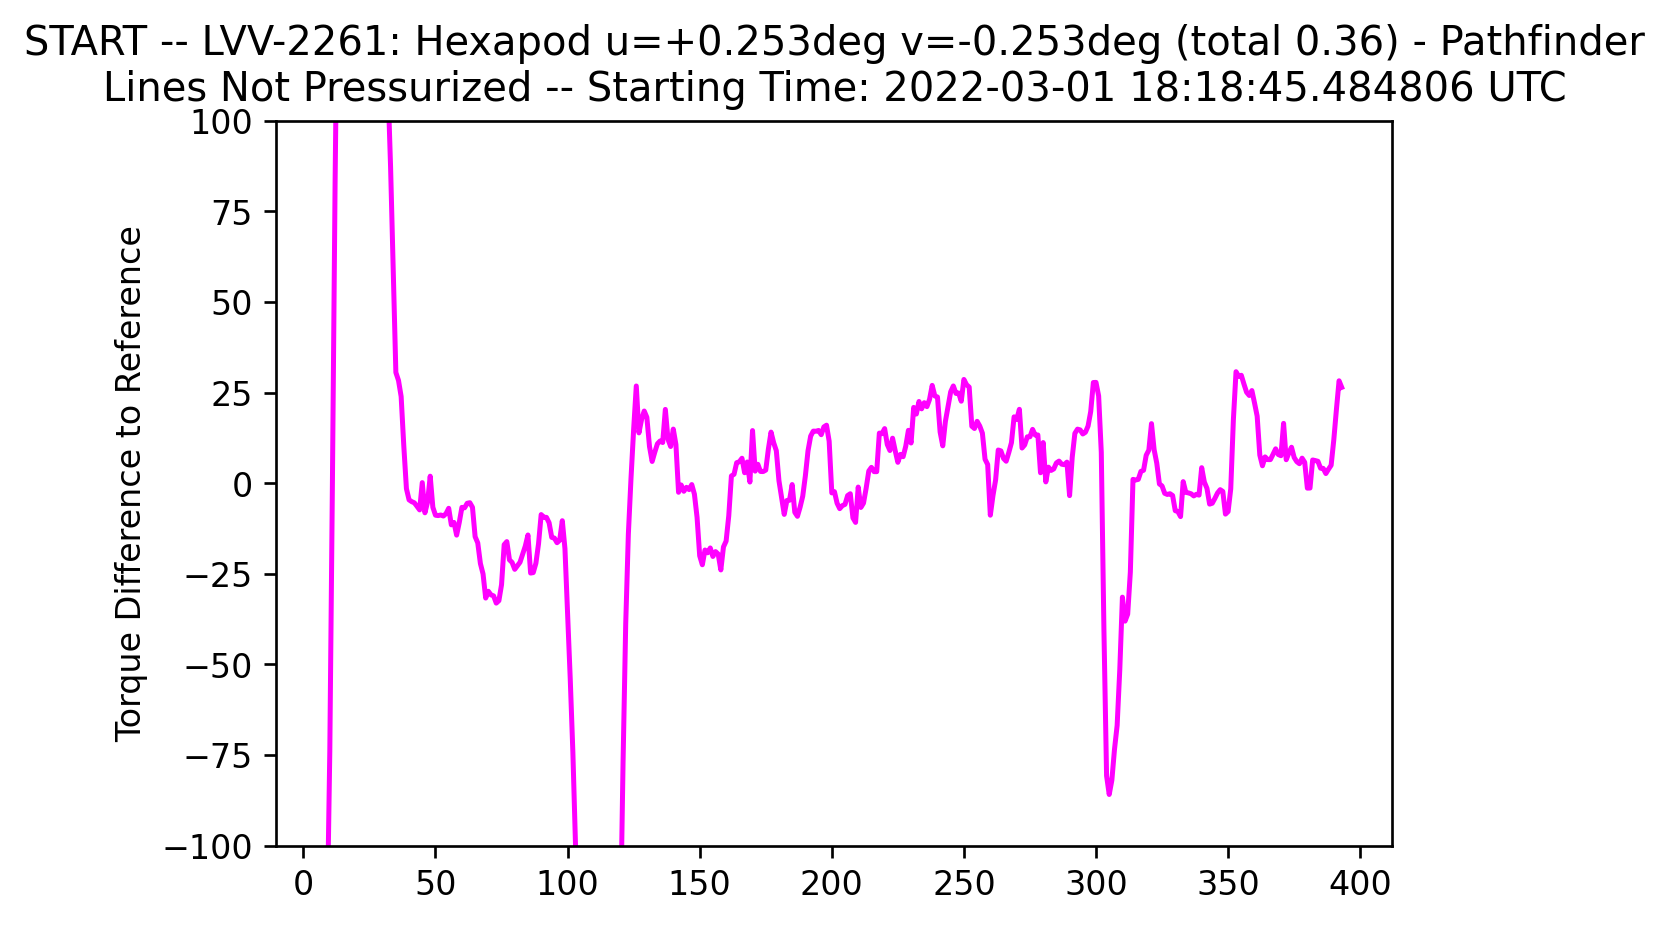

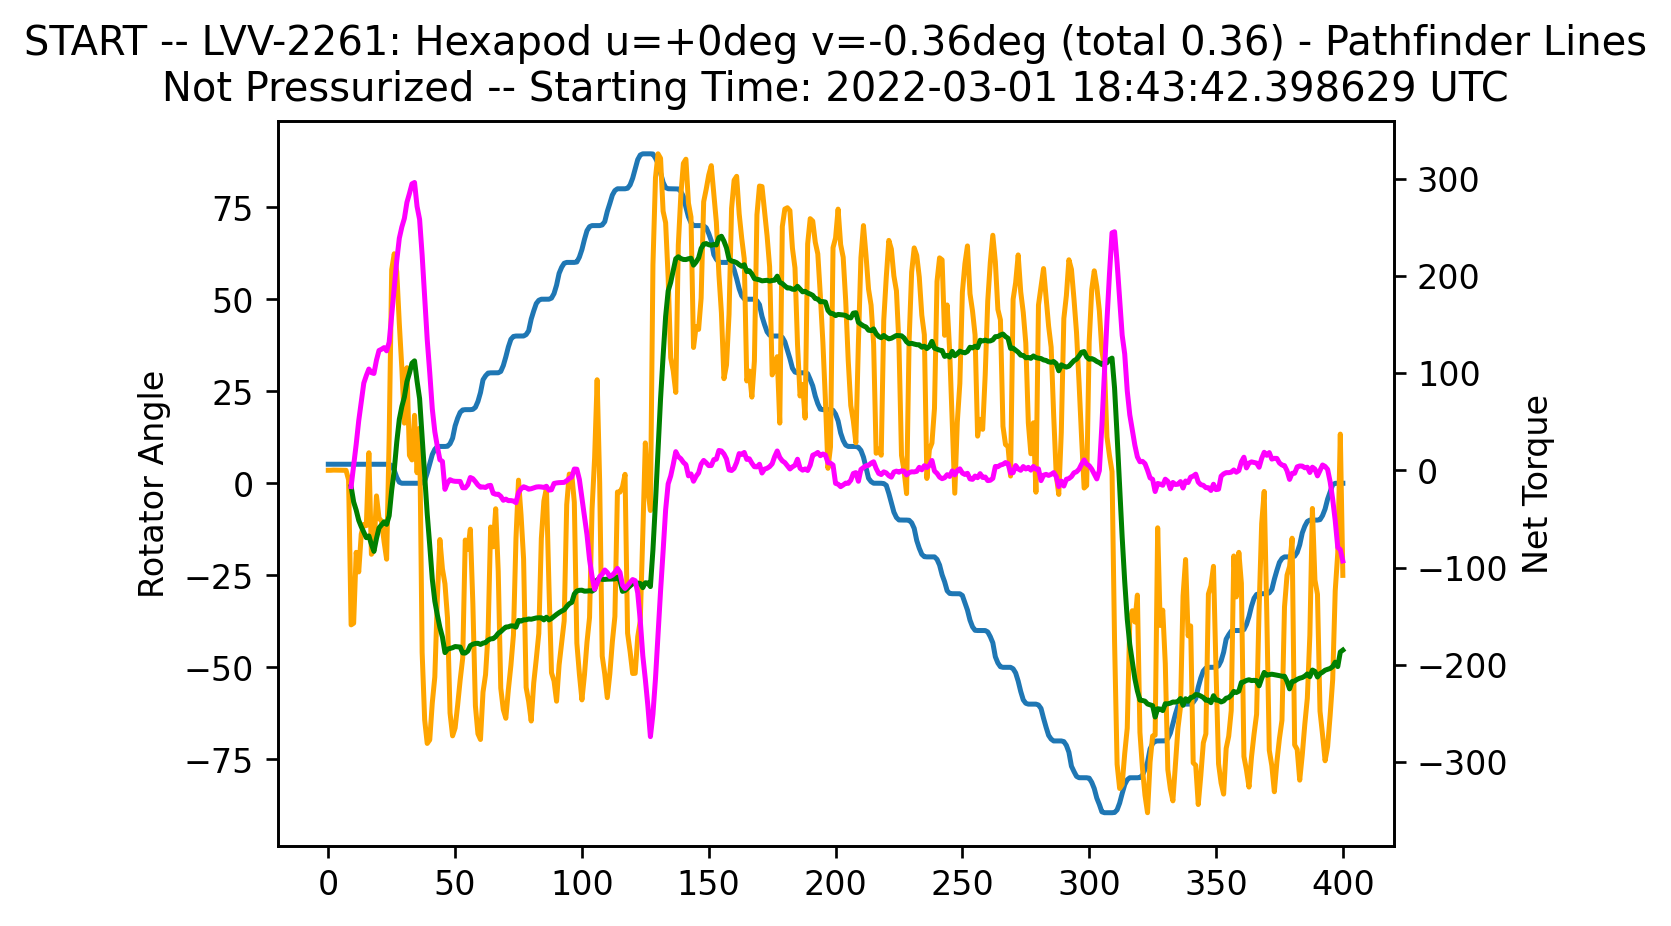

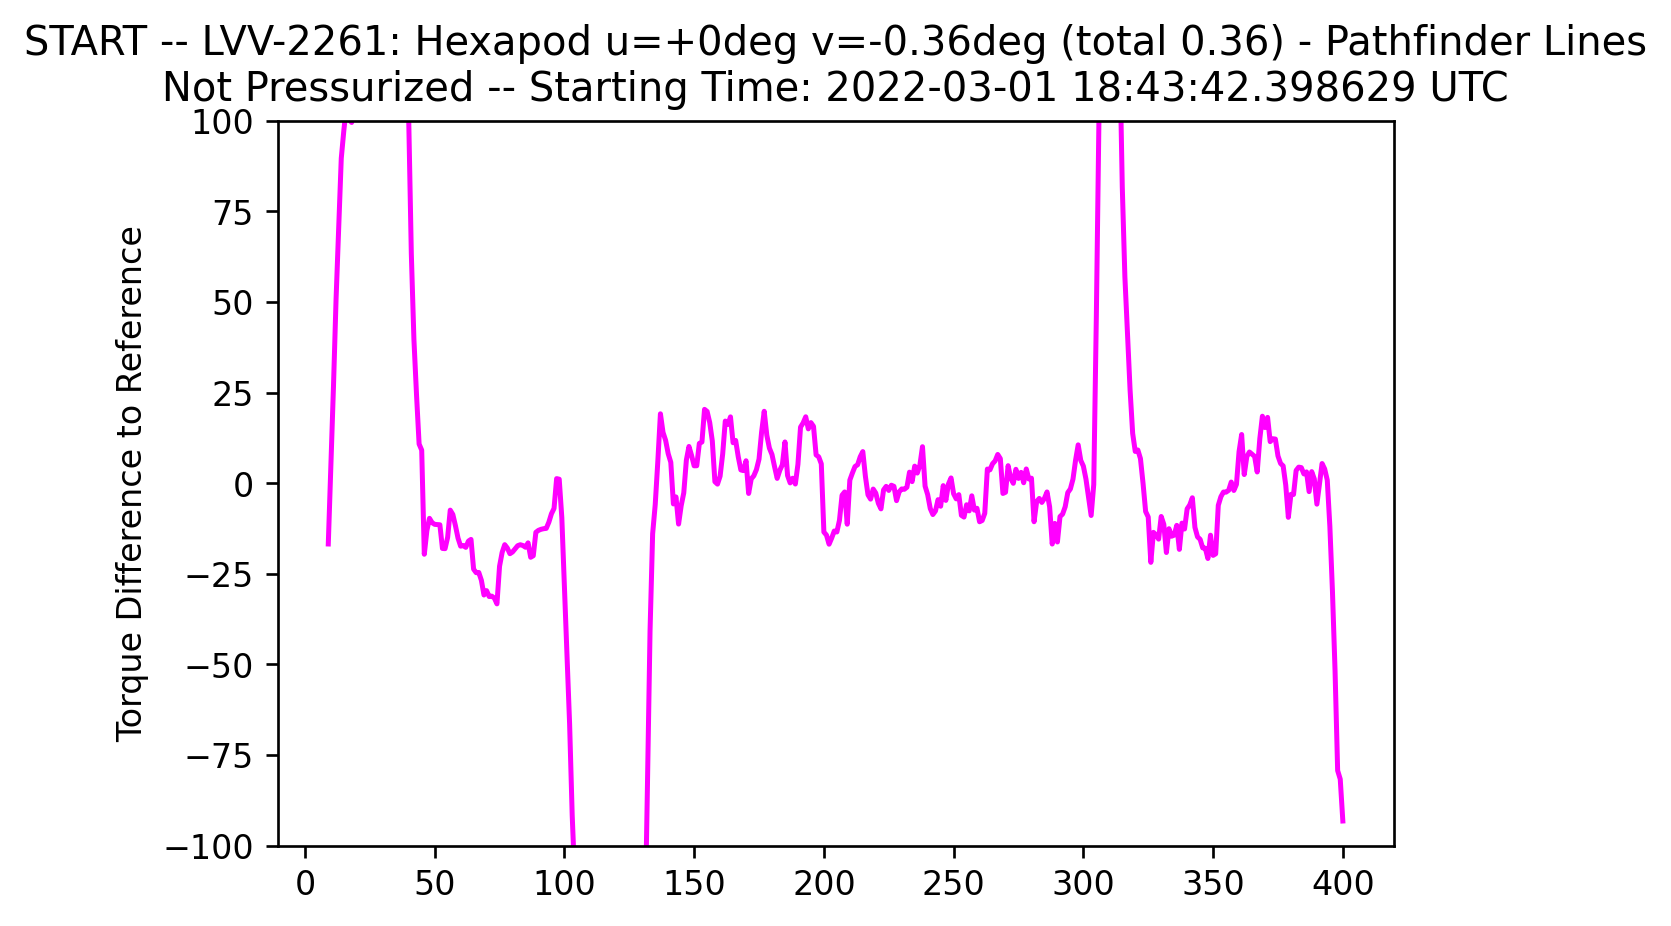

In [39]:
rotation_window = True

if rotation_window:
    starting = [0, 520, 220, 390, 400, 115]
else:
    starting = [0, 0, 0, 0, 0, 0]

reference_df = dfs[0].copy() 
reference_df.reset_index(inplace=True)    
reference_rolling = reference_df.net_torque.rolling(window=10).mean() 
    

with PdfPages('/home/cwwalter/rotator.pdf') as pdf:
    for index,start in enumerate(starting):

        cut_df = dfs[index][start:].copy()
        cut_df.reset_index(inplace=True)
        cut_rolling = cut_df.net_torque.rolling(window=10).mean() 

        plt.figure()
        ax1 = cut_df.actualPosition.plot()
        ax2 = cut_df.net_torque.plot(ax=ax1.twinx(), color='orange') 

        if rotation_window:
            ax3 = cut_rolling.plot(ax=ax2, color='green') 
            ax4 = (cut_rolling-reference_rolling).plot(ax=ax2, color='magenta') 

        title_string = textwrap.fill(messages.message[runs[index]], 80)

        plt.title(title_string)
        ax1.set_ylabel('Rotator Angle')
        ax2.set_ylabel('Net Torque')
        pdf.savefig(bbox_inches='tight')

        if rotation_window:
            plt.figure()
            (cut_rolling-reference_rolling).plot(color='magenta') 

            plt.title(title_string)
            plt.ylabel('Torque Difference to Reference')
            plt.ylim(-100,100)
            pdf.savefig(bbox_inches='tight')